# Best Reciprocal Sqrt ?

**Seemingly minor variations** in the way we approach computing **Reciprocal Sqrt** can perform as much as **3 to 4 orders of magnitude**faster or slower. 

Which one you choose depends on your need for **accuracy, speed, reability, maintainability**.

### See which one scores highest in your needs assetsment!

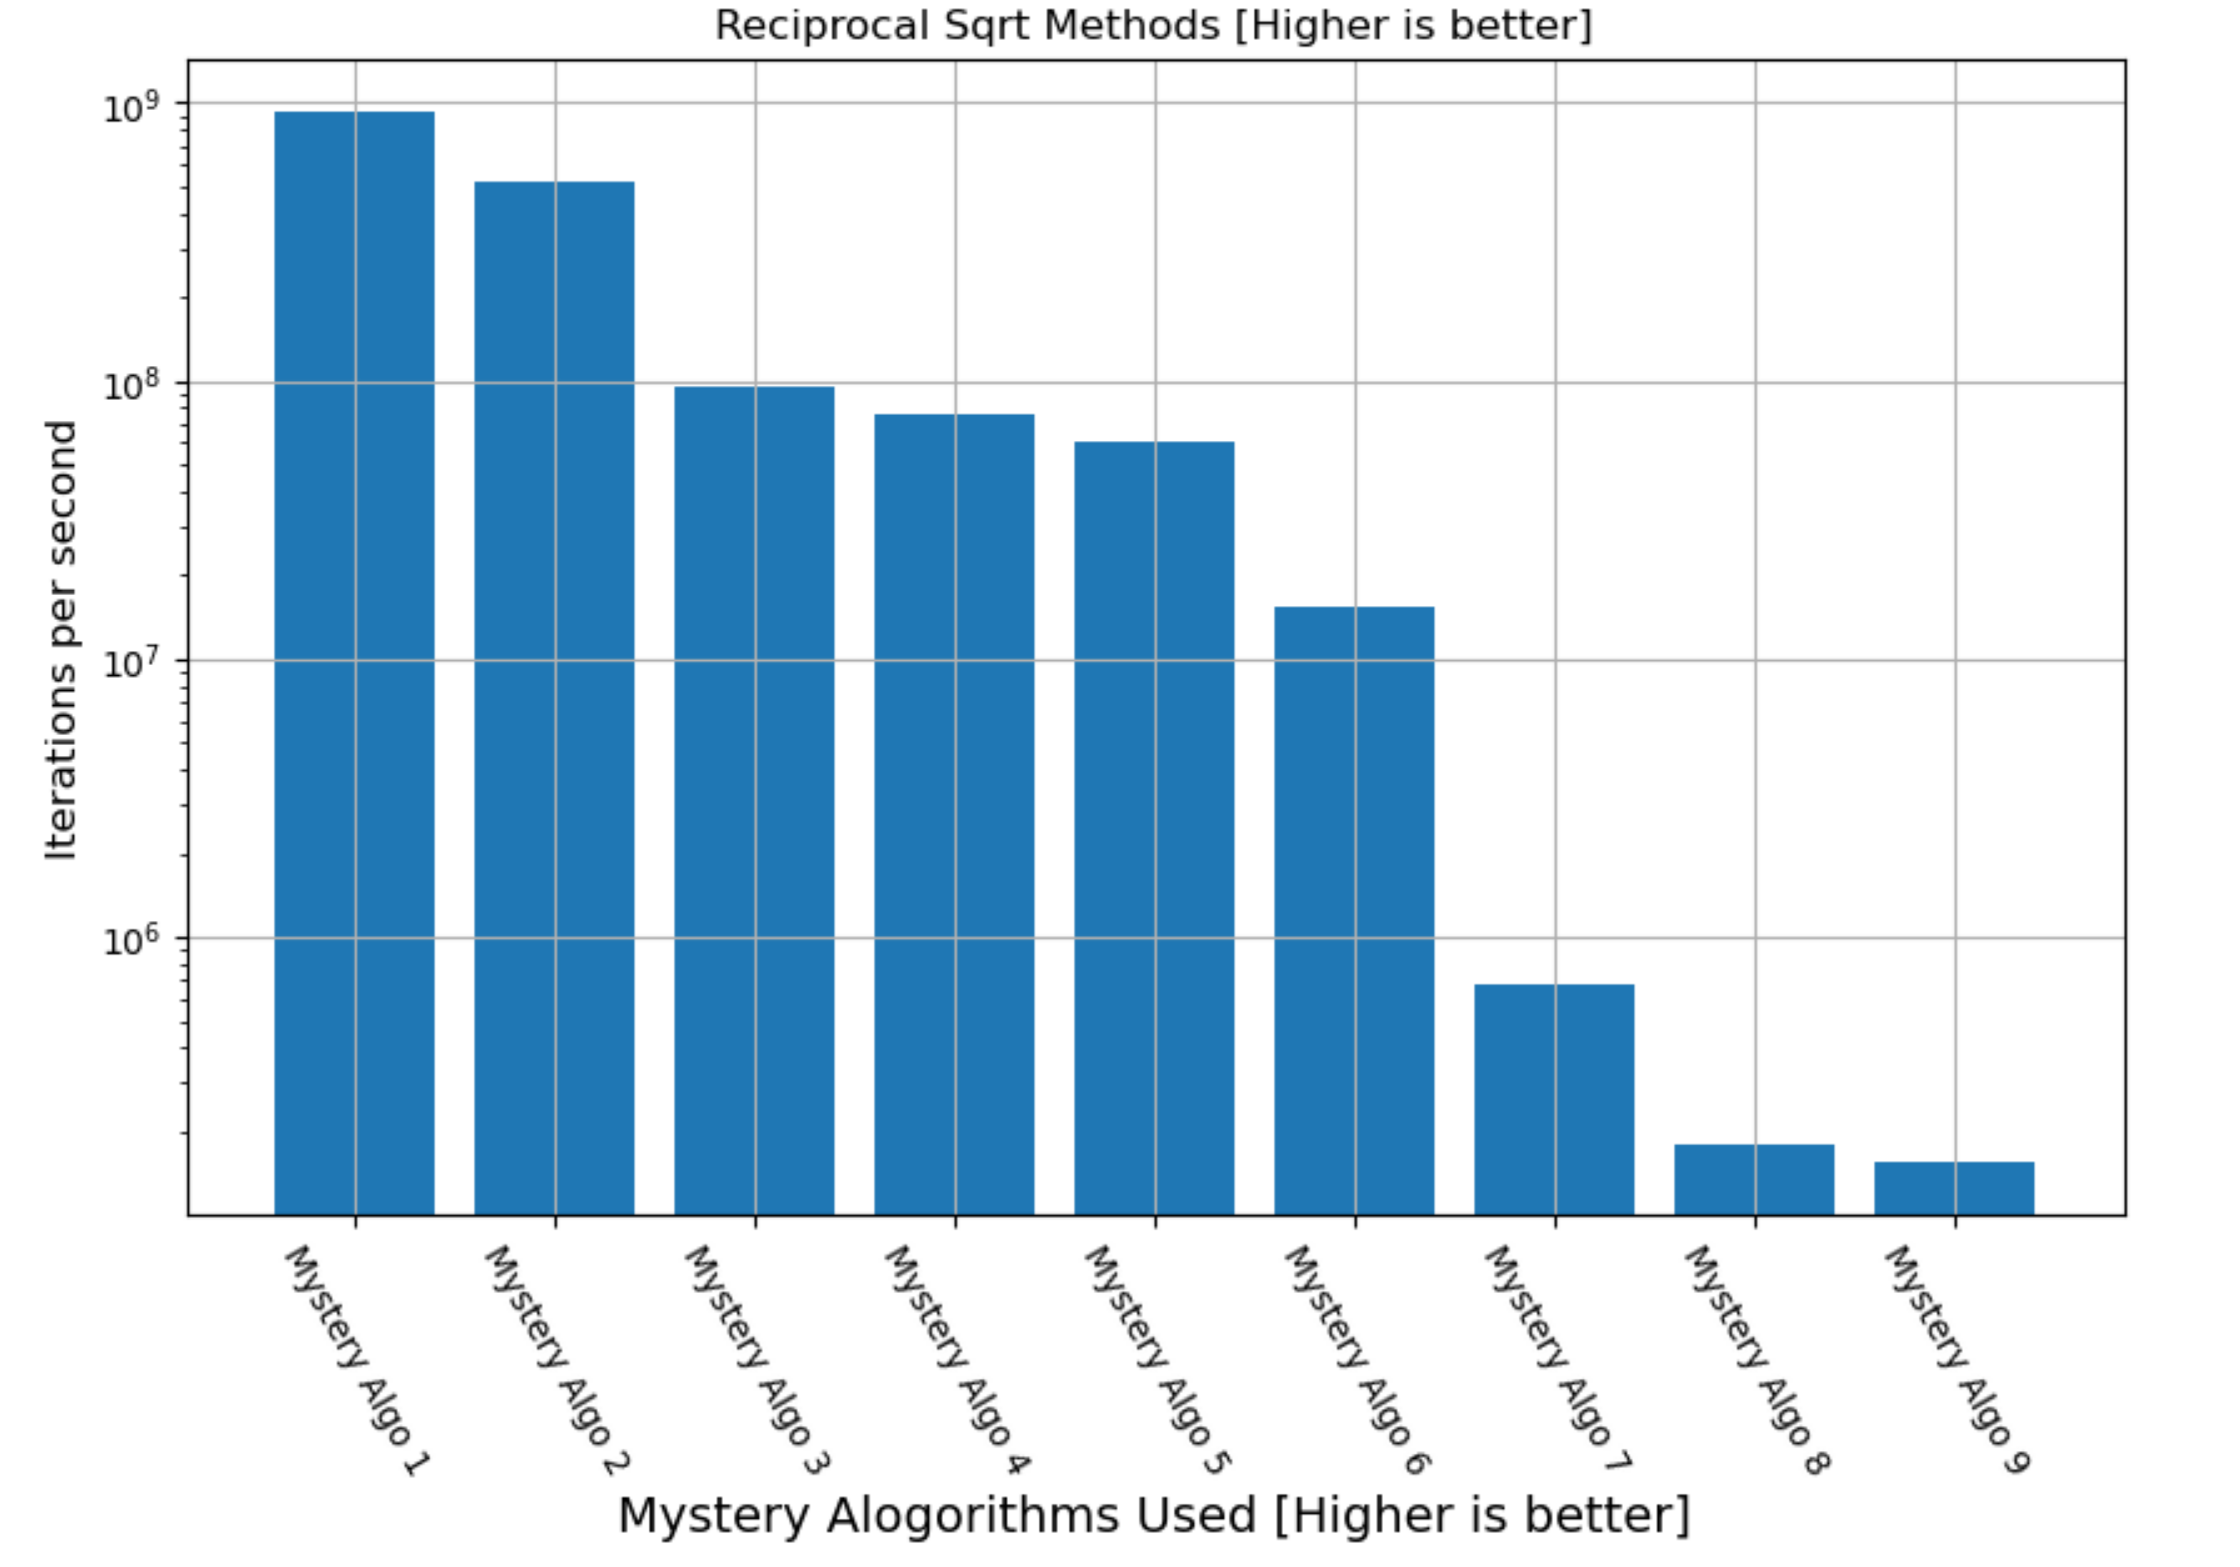

## Where is it used?
- ### Physics/ Engineering
    - ### Special Relativity Lorentz transformation
    - ## ${\displaystyle \gamma ={\frac {1}{\sqrt {1-{\frac {v^{2}}{c^{2}}}}}}}$
- ### 3D Graphics or ML applications needing normailization in space
    - #### vector normalization in video games and is mostly used in calculations involved in 3D programming
 
This is an intersting topic as the recent history of this computation shows a seesaw improvement in methods used

- Still find articles extolling virtue of Fast Reciprocal Sqrt as was implemeted in Quake III - Just an ingenious applicatiopn of Newton method to get fast approximations of this value
- Then the introduction by Intel of SSE instructions which compute reciprocal sqrt as part of SSE instruction set
- Where does it stand today?
- See article [Is Fast Inverse Square Root still Fast?](https://www.linkedin.com/pulse/fast-inverse-square-root-still-armin-kassemi-langroodi/?utm_source=share&utm_medium=member_android&utm_campaign=share_via)
- See article by ajcr
    - https://ajcr.net/fast-inverse-square-root-python/




## What we we test in this notebook?

In this workbook we will test the folloing approaches:

- PyTorch rsqrt:
    - Use torch built in function rsqrt()
- NumP_Compose RecipSqrt
    - Use NumPy np.reicprocal(np.sqrt())
- NumPy_Simple
    - Use Numpy implicit vectors: b = a**-.5
- Cython_Simple
    - Use Cython variant of Simple a**-.5
- Numba_Simple
    - Use Numba njit varaint of Simple a**-.5
- Brute Force List Comprehension element by element
    - Brute force loop approach no vectorization at all
- FRSNewton-RaphsonLoop
    - Fast Reciprocal Sqrt using Newton Raphson and Quake III approach
- FRSNewton-RaphsonVectorize
    - Fast Reciprocal Sqrt using Newton Raphson and Quake III approach vecortized with np.apply
- FRSNewton-RaphsonSNewtonCython
    - Fast Reciprocal Sqrt using Newton Raphson and Quake III approach in Cython

In [1]:
# Text color values
rd = '\033[91m'
gr = '\033[92m'
yl = '\033[93m'
bl = '\033[94m'
pk = '\033[95m'
tl = '\033[96m'
gy = '\033[97m'
bk = '\033[0m'

import time
import math
N =  1_000_000
a = [i for i in range(1, N)]
b = []
timing = {}

In [2]:
t1 = time.time()
b = [1.0/math.sqrt(x) for x in a]
t2 = time.time()
timing[f'BruteForceLoopExact'] = N/(t2-t1)
print(f"elapsed {rd}{N/(t2-t1):,.1f} iter/sec{bk}")
b[:5]  # aproximate answer

elapsed 14,497,711.8 iter/sec


[1.0, 0.7071067811865475, 0.5773502691896258, 0.5, 0.4472135954999579]

# Apply imprecise Newton Fast approx

Adapted from wikipedia article about fast inverse square root

- [Wikipedia:_Fast_inverse_square_root](https://en.wikipedia.org/wiki/Fast_inverse_square_root)

And excellent blog write up by ajcr
- [acjr.net:The_Fast_Inverse_Square_Root_method_in_Python](https://ajcr.net/fast-inverse-square-root-python/)
- This article, after comparing several mehtods for computing reciprocal sqrt on **single value** recommends just using:
```python
a**-.5
```

Lets try vectorizing this function which **appoximates reciprocal sqrt using newton method**

In [3]:
from ctypes import c_float, c_int32, cast, byref, POINTER
import time

def ctypes_isqrt(number):  # operates on single value at a time
    threehalfs = 1.5
    x2 = number * 0.5
    y = c_float(number)

    i = cast(byref(y), POINTER(c_int32)).contents.value
    i = c_int32(0x5f3759df - (i >> 1))
    y = cast(byref(i), POINTER(c_float)).contents.value

    y = y * (1.5 - (x2 * y * y))
    return y

In [4]:
try:
    b = ctypes_isqrt(a)
except:
    print("Can't handle list or ndarray - just single value")

Can't handle list or ndarray - just single value


In [5]:
t1 = time.time()
b = []
for i in range(1,  N ):
    b.append(ctypes_isqrt(i))
t2 = time.time()
timing[f'FRSNewton Brute Force Loop'] = N/(t2-t1)
print(f"elapsed {rd}{N/(t2-t1):,.1f} iter/sec{bk}")
b[:5]  # aproximate answer

elapsed 657,473.0 iter/sec


[0.9983071495847821,
 0.7069300386983334,
 0.576846835782431,
 0.49915357479239103,
 0.4471410099094477]

# Assume we will do NumPy coversion 

for rest of cells in notebook

In [6]:
import time
import numpy as np

a = np.array([i for i in range(1,     N)])
a = np.expand_dims(a, axis = 0)  # make the array the right sahpe for use by apply

### NumPy apply (vectorize along axis)

In [7]:
t1 = time.time()
b = np.apply_along_axis(ctypes_isqrt, 0, a)
t2 = time.time()
timing['FRSNewtonVectorize'] = N/(t2-t1)
print(f"elapsed {rd}{N/(t2-t1):,.1f} iter/sec{bk}")
b[:5]  # aproximate answer

elapsed 170,169.2 iter/sec


array([[9.98307150e-01, 7.06930039e-01, 5.76846836e-01, ...,
        9.98306080e-04, 9.98305582e-04, 9.98305085e-04]])

# Cython Newton Approximation Method

https://cython.readthedocs.io/en/latest/src/tutorial/cython_tutorial.html

In [8]:
import numpy as np
a = np.array([i for i in range(1, N)])
a = np.expand_dims(a, axis = 0)  # make the array the right sahpe for use by apply


### Time compute for single value

As Cython can accept almost any valid python source file, one of the hardest things in getting started is just figuring out how to compile your extension.

```python
def ctypes_nbsqrt(number):  # operates on single value at a time
    from ctypes import c_float, c_int32, cast, byref, POINTER
    threehalfs = 1.5
    x2 = number * 0.5
    y = c_float(number)

    i = cast(byref(y), POINTER(c_int32)).contents.value
    i = c_int32(0x5f3759df - (i >> 1))
    y = cast(byref(i), POINTER(c_float)).contents.value

    y = y * (1.5 - (x2 * y * y))
    return y
```
Save this code in a file named **cython_NewtonRecipSqrt.pyx**. Now we need to create the setup.py, which is like a python Makefile (for more information see Source Files and Compilation). Your **setup.py** should look like:

```python
from setuptools import setup
from Cython.Build import cythonize

setup(
    ext_modules = cythonize("helloworld.pyx")
)
```

To use this to build your Cython file use the commandline options:

```bash
$ python setup.py build_ext --inplace
```

Which will leave a file in your local directory called helloworld.so in unix or helloworld.pyd in Windows. Now to use this file: start the python interpreter and simply import it as if it was a regular python module:

In [9]:
!python setup.py build_ext --inplace 

Compiling cython_NewtonRecipSqrt.pyx because it changed.
[1/1] Cythonizing cython_NewtonRecipSqrt.pyx
/opt/intel/oneapi/intelpython/latest/lib/python3.9/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /home/u9999ad7367849478acc6568ce06912b/NumPyOpt/NumPy_Optimizations/cython_NewtonRecipSqrt.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


### The shared object is now available

from the shared object, import the function

In [10]:
from cython_NewtonRecipSqrt import ctypes_nbsqrt
t1 = time.time()
print("estimate 1/sqrt(16)", ctypes_nbsqrt(16) ) # FOr a single value
t2 = time.time()
print(f"elapsed single calc {(t2-t1):,.1f} sec")


estimate 1/sqrt(16) 0.24957678739619552
elapsed single calc 0.0 sec


In [11]:
t1 = time.time()
b = np.apply_along_axis(ctypes_nbsqrt, 0, a)
t2 = time.time()
timing['FRSNewtonCython'] = N/(t2-t1)
print(f"elapsed {rd}{N/(t2-t1):,.1f} iter/sec{bk}")
b[:5]  # aproximate answer

elapsed 155,624.0 iter/sec


array([[9.98307150e-01, 7.06930039e-01, 5.76846836e-01, ...,
        9.98306080e-04, 9.98305582e-04, 9.98305085e-04]])

In [12]:
# ctypes_isqrt(a)   #error

# Cython Simple  Method

- Edit & save:  **cython_Exact.pyx**
   
```python
def ctypes_Exsqrt(x):  # operates on single value at a time
    y = x**(-.5)
    return y
```

- edit & save **setup.py**
  ```python
    from distutils.core import setup
    from Cython.Build import cythonize
    setup(ext_modules = cythonize('cython_NewtonRecipSqrt.pyx'))
    setup(ext_modules = cythonize('cython_Exact.pyx'))
```

- python setup.py build_ext --inplace
- setup(ext_modules = cythonize('cython_Exact.pyx')) creates cython_Eact.so



- now we can import using in Jupyter:

```python
    from cython_Exact import ctypes_Exsqrt
```

In [13]:
from cython_Exact import ctypes_Exsqrt

In [14]:
t1 = time.time()
b = ctypes_Exsqrt(a)
t2 = time.time()
timing['CythonE Simple'] = N/(t2-t1)
print(f"elapsed {gr}{N/(t2-t1):,.1f} iter/sec{bk}")
b[:5]  # aproximate answer

elapsed 65,027,969.0 iter/sec


array([[1.        , 0.70710678, 0.57735027, ..., 0.001     , 0.001     ,
        0.001     ]])

# Numba Simple approach
https://numba.pydata.org/numba-doc/latest/user/jit.html

```python
@numba.njit
def ctypes_nbsqrt(number):  # operates on single value at a time
  return number ** -0.5
    
ctypes_nbsqrt(a)
```

In [15]:
import numba
import numpy as np
N = 100_000_000
a = np.array([i for i in range(1, N)])
#a = np.expand_dims(a, axis = 0)  # make the array the right sahpe for use by apply

@numba.njit
def ctypes_nbsqrt(number):  # operates on single value at a time
  return number ** -0.5

In [16]:
t1 = time.time()
ctypes_nbsqrt(a)
t2 = time.time()
timing['Numba Simple'] = N/(t2-t1)
print(f"elapsed {gr}{N/(t2-t1):,.1f} iter/sec{bk}")
b[:5]  # aproximate answer

elapsed 64,202,336.9 iter/sec


array([[1.        , 0.70710678, 0.57735027, ..., 0.001     , 0.001     ,
        0.001     ]])

# Assume we have converted "a" to NumPy

In [17]:
import numpy as np
a = np.array([i for i in range(1, N)])

### NumPy Compose

```python
b = np.reciprocal(np.sqrt(a))
```

In [18]:
t1 = time.time()
b = np.reciprocal(np.sqrt(a))
t2 = time.time()
timing['NumPy_Compose RecipSqrt'] = N/(t2-t1)
print(f"elapsed {gr}{N/(t2-t1):,.1f} iter/sec{bk}")
b[:5]  # aproximate answer

elapsed 50,606,168.2 iter/sec


array([1.        , 0.70710678, 0.57735027, 0.5       , 0.4472136 ])

## Numpy Simple minded 
```python
b =a**-.5
```

In [19]:
t1 = time.time()
b = a**-.5
t2 = time.time()
timing['NumPy_Simple'] = N/(t2-t1)
print(f"elapsed {gr}{N/(t2-t1):,.1f} iter/sec{bk}")
b[:5]  # aproximate answer

elapsed 77,520,872.2 iter/sec


array([1.        , 0.70710678, 0.57735027, 0.5       , 0.4472136 ])

# PyTorch rsqrt

```python
b = torch.rsqrt(torch.tensor(a))
```

In [20]:
# import torch
# t1 = time.time()
# b = torch.rsqrt(torch.tensor(a))
# t2 = time.time()
# timing['PyTorch rsqrt'] = N/(t2-t1)
# print(f"elapsed {gr}{N/(t2-t1):,.1f} iter/sec{bk}")
# b[:5]  # aproximate answer

Speedup :  498 X


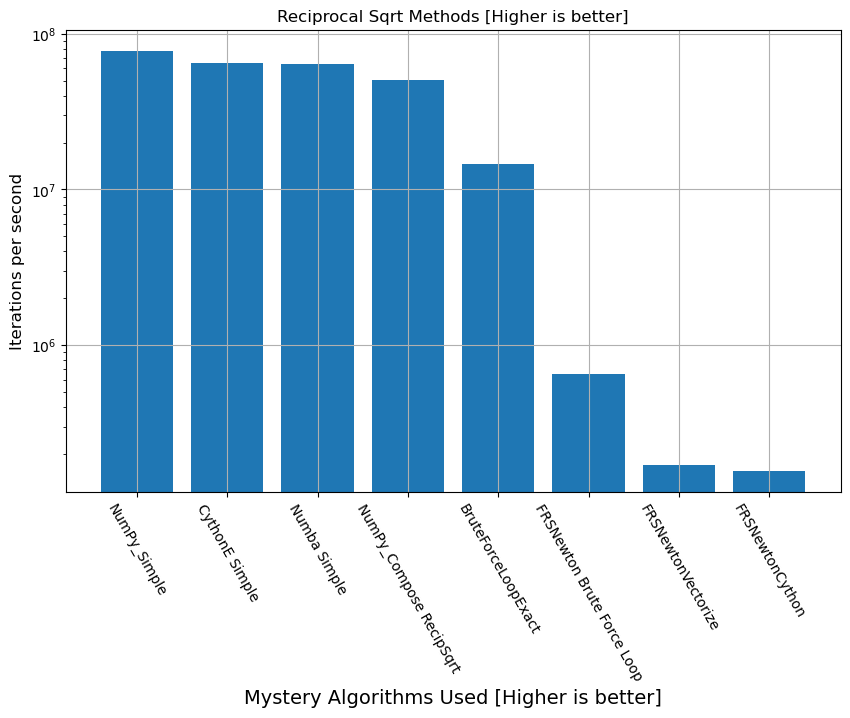

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.title("Reciprocal Sqrt Methods [Higher is better]")
plt.ylabel("Iterations per second",fontsize=12)
plt.xlabel("Mystery Algorithms Used [Higher is better]",fontsize=14)
plt.grid(True)
plt.yscale('log')
plt.xticks(rotation=-60)
timingH = dict(sorted(timing.items(), key=lambda x:x[1], reverse=True))
plt.bar(x = range(len(timingH)), height=timingH.values(), align='center', tick_label=list(timingH.keys()))
mysteryList = [f'Mystery Algo {i+1}' for i in range(len(timingH))]
#plt.bar(x = range(len(timingH)), height=timingH.values(), align='center', tick_label=mysteryList)
short = min(list(timingH.values()))
long = max(list(timingH.values()))
print('Speedup : {:4.0f} X'.format(long/short))

# Incomplete Experiments

### Use Intel compiler to make shared onject (so)

On DevCLoud:
- After the python setup.py ..., then compile the generated .C file with intel compiler as follows:

```python
icx-cc -fPIC -shared -o bob_cython.so cython_Exact.c -I../../intel/oneapi/intelpython/python3.9/include/python3.9/

```

On your laptop:
- Download from here: https://www.intel.com/content/www/us/en/developer/articles/tool/oneapi-standalone-components.html#dpcpp-cpp


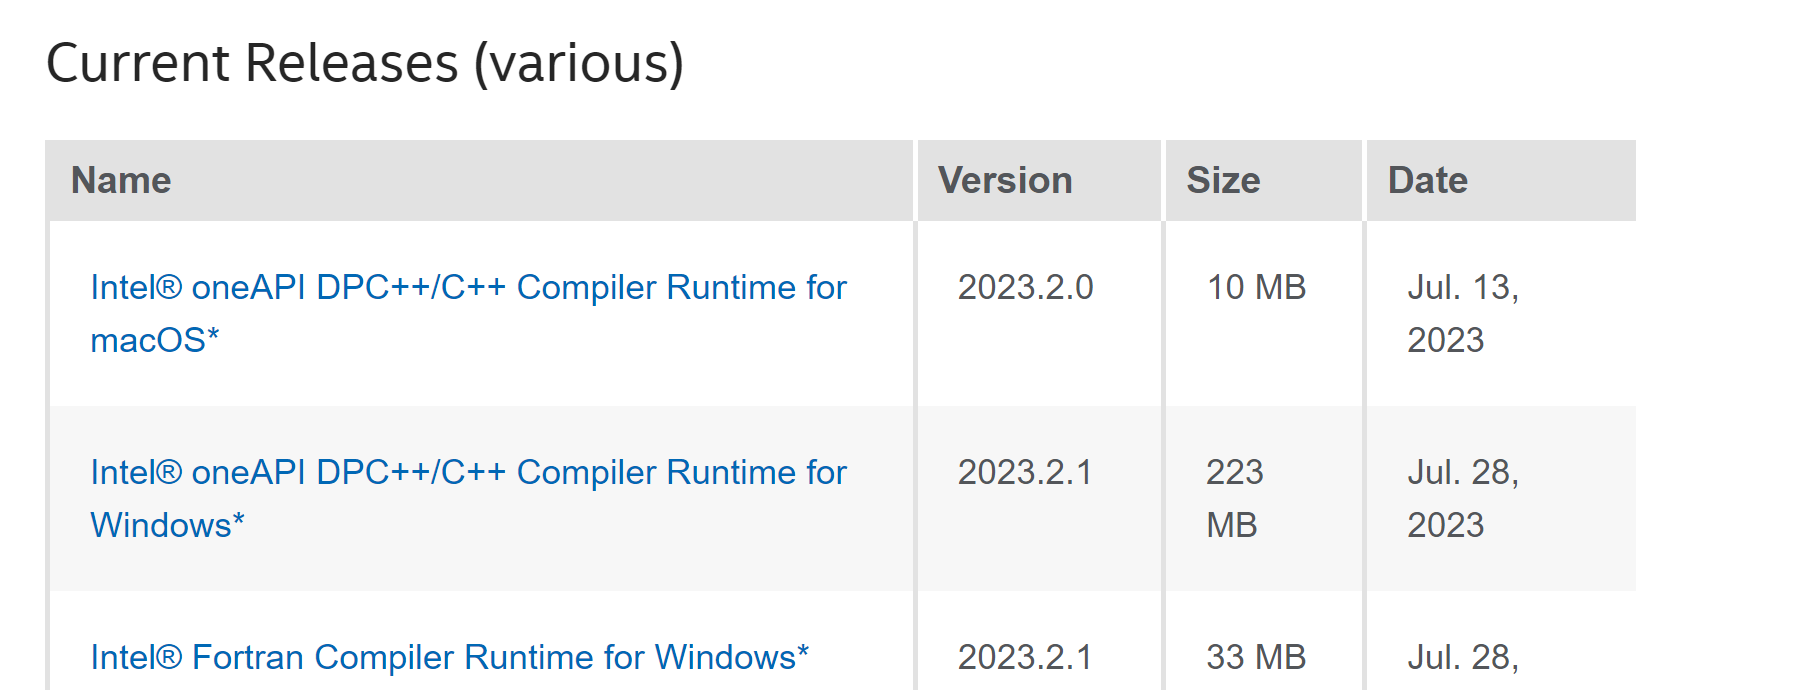


- Install on linux (WSL: Ubunutu)

```bash
sh Downloads/l_dpcpp-cpp-compiler_p_2023.2.1.8_offline.sh

source intel/oneapi/setvars.sh intel64 --force

cd Examples/python/

icx-cc -fPIC -shared -o bob_cython.so cython_Exact.c -I../../intel/oneapi/intelpython/python3.9/include/python3.9/

```

DID NOT GET THE COMPILER PART TO WORK YET


In [22]:
!lscpu

Architecture:            x86_64
  CPU op-mode(s):        32-bit, 64-bit
  Address sizes:         52 bits physical, 57 bits virtual
  Byte Order:            Little Endian
CPU(s):                  224
  On-line CPU(s) list:   0-223
Vendor ID:               GenuineIntel
  Model name:            Intel(R) Xeon(R) Platinum 8480+
    CPU family:          6
    Model:               143
    Thread(s) per core:  2
    Core(s) per socket:  56
    Socket(s):           2
    Stepping:            8
    CPU max MHz:         3800.0000
    CPU min MHz:         800.0000
    BogoMIPS:            4000.00
    Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mc
                         a cmov pat pse36 clflush dts acpi mmx fxsr sse sse2 ss 
                         ht tm pbe syscall nx pdpe1gb rdtscp lm constant_tsc art
                          arch_perfmon pebs bts rep_good nopl xtopology nonstop_
                         tsc cpuid aperfmperf tsc_known_freq pni pclmulqdq dtes6
   

In [23]:
!free -g -h -t

               total        used        free      shared  buff/cache   available
Mem:           503Gi       7.6Gi        32Gi       5.0Gi       463Gi       487Gi
Swap:             0B          0B          0B
Total:         503Gi       7.6Gi        32Gi


### How to Call Fortran from Python

https://www.matecdev.com/posts/fortran-in-python.html

In [24]:
!f2py3 -c -m myflib my_fortran_lib.f90

running build
running config_cc
INFO: unifing config_cc, config, build_clib, build_ext, build commands --compiler options
running config_fc
INFO: unifing config_fc, config, build_clib, build_ext, build commands --fcompiler options
running build_src
INFO: build_src
INFO: building extension "myflib" sources
INFO: f2py options: []
INFO: f2py:> /tmp/tmpx5zrv_6x/src.linux-x86_64-3.9/myflibmodule.c
creating /tmp/tmpx5zrv_6x/src.linux-x86_64-3.9
Reading fortran codes...
	Reading file 'my_fortran_lib.f90' (format:free)
Post-processing...
	Block: myflib
			Block: foo
appenddecl: "dimension" not implemented.
Applying post-processing hooks...
  character_backward_compatibility_hook
Post-processing (stage 2)...
Building modules...
    Building module "myflib"...
    Generating possibly empty wrappers"
    Maybe empty "myflib-f2pywrappers2.f90"
    Maybe empty "myflib-f2pywrappers.f"
		Creating wrapper for Fortran function "foo"("foo")...
        Constructing wrapper function "foo"...
          b =

In [25]:
import myflib
import numpy as np

a = np.array([[1,2,3,4], [5,6,7,8]], order='F')
myflib.foo(a)

array([[ 0.54030231+0.84147098j, -0.41614684+0.90929743j,
        -0.9899925 +0.14112001j, -0.65364362-0.7568025j ],
       [ 0.28366219-0.95892427j,  0.96017029-0.2794155j ,
         0.75390225+0.6569866j , -0.14550003+0.98935825j]])